# New Section

In [1]:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
	
from tensorflow.keras import layers, Model, Input

from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from tqdm import tqdm
import cv2
import numpy as np
import random
import os
from random import shuffle 

In [3]:
import zipfile as zp
os.makedirs('content/data', exist_ok=True)


In [4]:
train_dir = '/content/data/train'
test_dir = '/content/data/test'
IMG_Size = 128

train_zip = zp.ZipFile('/content/drive/MyDrive/Google_Colab/train.zip')
train_zip.extractall('/content/data')
test_zip = zp.ZipFile('/content/drive/MyDrive/Google_Colab/test.zip')
test_zip.extractall('/content/data')

# New Section

In [5]:
from tqdm import tqdm
import cv2

In [6]:
image_path_train = list(os.listdir(train_dir))
random.shuffle(image_path_train)

In [7]:
def label_img(img):
  word_label = img.split('.')[-3]
  if word_label == 'cat': return 0
  elif word_label == 'dog': return 1


In [8]:
def Get_data_labels(image_path):
  list_image = []
  labels = []
  for imagePath in tqdm(image_path):
      path = os.path.join(train_dir,imagePath)
      image = cv2.imread(path)
      image = cv2.resize(image, (IMG_Size,IMG_Size))
      image = np.array(image)
      image = np.expand_dims(image, 0)
      image = imagenet_utils.preprocess_input(image)
      list_image.append(image)
      labels.append(label_img(imagePath))
      
  list_image = np.vstack(list_image)
  labels = np.vstack(labels)
  return (list_image, labels)


In [9]:
list_image, labels = Get_data_labels(image_path_train)
X_train, y_train = list_image[:20000], labels[:20000]
X_test, y_test = list_image[20000:25000], labels[20000:25000]

100%|██████████| 25000/25000 [00:57<00:00, 431.53it/s]


In [10]:
from tensorflow import keras
from tensorflow.keras import layers
# these are a new feature in TF 2.2
from tensorflow.keras.layers.experimental import preprocessing


pretrained_base = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

model = keras.Sequential([
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
# augmentation cho training data
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
# augementation cho test
aug_test= ImageDataGenerator(rescale=1./255)

In [12]:
for layer in pretrained_base.layers:
    layer.trainable = False
opt = RMSprop(0.001)
#opt = 'adam'
model.compile(opt, 'binary_crossentropy', ['binary_accuracy'])
numOfEpoch = 25
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=64), 
                        steps_per_epoch=len(X_train)/128,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=64)),
                        validation_steps=len(X_test)/128,
                        epochs=numOfEpoch)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
156/156 [==============================] - 78s 282ms/step - loss: 0.6094 - binary_accuracy: 0.7449 - val_loss: 0.2742 - val_binary_accuracy: 0.8777
Epoch 2/25
156/156 [==============================] - 42s 267ms/step - loss: 0.3706 - binary_accuracy: 0.8354 - val_loss: 0.2803 - val_binary_accuracy: 0.8824
Epoch 3/25
156/156 [==============================] - 42s 269ms/step - loss: 0.3462 - binary_accuracy: 0.8460 - val_loss: 0.2502 - val_binary_accuracy: 0.8906
Epoch 4/25
156/156 [==============================] - 42s 269ms/step - loss: 0.3252 - binary_accuracy: 0.8581 - val_loss: 0.2557 - val_binary_accuracy: 0.8805
Epoch 5/25
156/156 [==============================] - 42s 269ms/step - loss: 0.3202 - binary_accuracy: 0.8614 - val_loss: 0.2312 - val_binary_accuracy: 0.9008
Epoch 6/25
156/156 [==============================] - 42s 267ms/step - loss: 0.3197 - binary_accuracy: 0.8594 - val_loss: 0.2440 - val_binary_accuracy: 0.8934
Epoch 7/25
156/156 [==========================

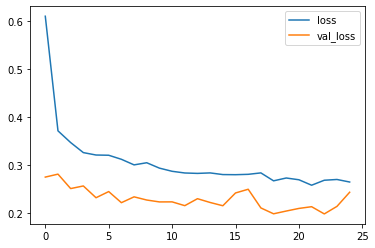

In [13]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
history_frame = pd.DataFrame(H.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [22]:
pretrained_base = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

model = keras.Sequential([
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    # layers.Dense(256, activation = 'relu'),
    # layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 8193      
Total params: 14,722,881
Trainable params: 14,722,881
Non-trainable params: 0
_________________________________________________________________


In [23]:
for layer in pretrained_base.layers:
    layer.trainable = False

opt = RMSprop(0.001)
model.compile(opt, 'binary_crossentropy', ['binary_accuracy'])

numOfEpoch = 20

H_new = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=64), 
                        steps_per_epoch=len(X_train)/128,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=64)),
                        validation_steps=len(X_test)/128,
                        epochs=numOfEpoch)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
156/156 [==============================] - 42s 264ms/step - loss: 0.4581 - binary_accuracy: 0.7797 - val_loss: 0.3016 - val_binary_accuracy: 0.8590
Epoch 2/20
156/156 [==============================] - 41s 263ms/step - loss: 0.3512 - binary_accuracy: 0.8417 - val_loss: 0.2511 - val_binary_accuracy: 0.8945
Epoch 3/20
156/156 [==============================] - 41s 263ms/step - loss: 0.3223 - binary_accuracy: 0.8618 - val_loss: 0.2510 - val_binary_accuracy: 0.8859
Epoch 4/20
156/156 [==============================] - 41s 261ms/step - loss: 0.3147 - binary_accuracy: 0.8646 - val_loss: 0.2295 - val_binary_accuracy: 0.9008
Epoch 5/20
156/156 [==============================] - 41s 261ms/step - loss: 0.3090 - binary_accuracy: 0.8619 - val_loss: 0.2572 - val_binary_accuracy: 0.8855
Epoch 6/20
156/156 [==============================] - 41s 260ms/step - loss: 0.2977 - binary_accuracy: 0.8716 - val_loss: 0.2770 - val_binary_accuracy: 0.8852
Epoch 7/20
156/156 [==========================

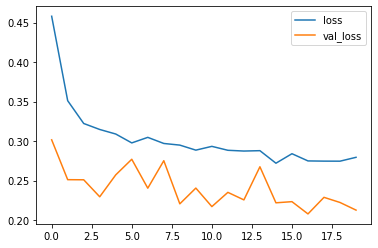

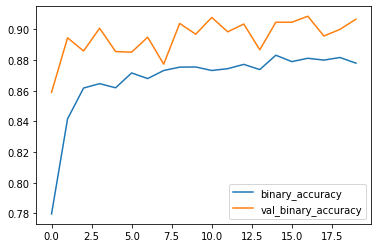

In [24]:
history_frame = pd.DataFrame(H_new.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# New Section